<a href="https://colab.research.google.com/github/YoniTint/trust-ai-project/blob/main/Robustness_of_Yolo_nano%2C_small%2C_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Loading libraries##

In [ ]:
pip install grad-cam

In [ ]:
pip install ultralytics

##Example on one image from the internet##

Using yolo5 model to detect a person

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


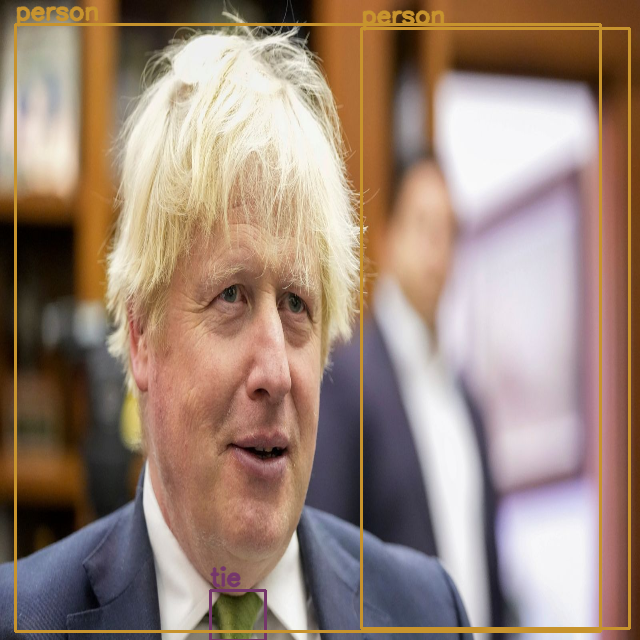

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
from google.colab.patches import cv2_imshow

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img



##Robustness of YOLO again attack##
Now we'll try to get results for a full data set. this dataset is taken from: https://datasets.activeloop.ai/docs/ml/datasets/celeba-dataset/.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/trust_ml/Data/only_first_100

/content/drive/MyDrive/Colab Notebooks/trust_ml/Data/only_first_100


In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt

BASIC_PATH = "/content/drive/MyDrive/Colab Notebooks/trust_ml/Data/"
FEATURE_PATH = os.path.join(BASIC_PATH,'list_attr_celeba.csv')
IMG_PATH = os.path.join(BASIC_PATH,'only_first_100/only_first_100')
NM_IMGS = 100
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(FEATURE_PATH, nrows=NM_IMGS)
df.head()



,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,...,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,...,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,...,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,...,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,...,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,...,-1,1,-1,-1,1


In [ ]:
from google.colab.patches import cv2_imshow
outputs_folder = r"/content/drive/MyDrive/Colab Notebooks/trust_ml/output_large"


iters = list()
min_delta = []
for index in range(0, NM_IMGS):
    img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
    img = cv2.resize(img, (640, 640))
    rgb_img = img.copy()
    img = np.float32(img) / 255
    transform = transforms.ToTensor()
    tensor = transform(img).unsqueeze(0)

    model = torch.hub.load('ultralytics/yolov5', 'yolov5l', pretrained=True)
    model.eval()
    model.cpu()
    target_layers = [model.model.model.model[-2]]

    results = model([rgb_img])
    boxes, colors, names = parse_detections(results)
    detections = draw_detections(boxes, colors, names, rgb_img.copy())
    Image.fromarray(detections)
    cam = EigenCAM(model, target_layers, use_cuda=False)
    grayscale_cam = cam(tensor)[0, :, :]
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    Image.fromarray(cam_image)
    colormap = cv2.COLORMAP_JET
    heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    Image.fromarray(heatmap)
    max_iter = 30
    delta = torch.zeros(img.shape[0], img.shape[1], 3, dtype=torch.float64)
    for i in range(max_iter):
      eps = 1e-5
      variance = 0.01
      delta = delta + variance * torch.randn(img.shape[0], img.shape[1], 3)  * 255
      # clip delta to be within [delta-eps, delta+eps]

      delta = torch.clamp(delta, delta-eps, delta + eps)
      # clip delta to be between 0 and 1
      # delta = torch.clamp(delta, 0, 1)
      delta[np.where(heatmap == 0)] = 0

      delta_img = cv2.applyColorMap(np.uint8(delta), colormap)
      delta_img[np.where(heatmap == 0)] = 0
      Image.fromarray(delta_img)

      img = cv2.imread(IMG_PATH + '/' + df.sample(NM_IMGS)["image_id"].values[index])
      img = cv2.resize(img, (640, 640))
      rgb_img = img.copy()
      noisy = rgb_img + delta_img

      # give predictions on noisy image
      results = model([noisy])
      boxes, colors, names = parse_detections(results)
      detections = draw_detections(boxes, colors, names, noisy.copy())
      Image.fromarray(detections)
      if (len(boxes) == 0) or (not 'person' in names):
        cv2.imwrite(f"{outputs_folder}/{index}.png", detections)
        #print(f'image {index} stopped after {i+1} iterations')
        min_delta.append(delta)
        iters.append(i)
        break
      elif i==max_iter-1:
        min_delta.append(delta)
        iters.append(i)

print("end")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 
Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-8-4 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape.

end


In [ ]:
min_delta

average = torch.mean(torch.stack(min_delta))
print(average)
print(NM_IMGS)
print(iters.count(29))
print(iters)
print(average/NM_IMGS)
print(sum(iters)/NM_IMGS)

tensor(-0.00029, dtype=torch.float64)
100
11
[4, 29, 2, 1, 0, 4, 2, 5, 0, 28, 1, 3, 4, 12, 0, 0, 0, 3, 0, 0, 1, 1, 0, 29, 0, 0, 4, 6, 1, 20, 0, 0, 4, 10, 9, 0, 0, 19, 0, 1, 0, 1, 0, 0, 0, 0, 0, 29, 1, 12, 26, 3, 0, 2, 0, 0, 1, 1, 29, 3, 5, 0, 0, 1, 29, 3, 8, 5, 29, 29, 1, 1, 29, 27, 5, 3, 0, 17, 2, 0, 0, 0, 2, 29, 2, 0, 7, 0, 1, 0, 29, 29, 1, 0, 1, 5, 1, 0, 0, 0]
tensor(-2.92323e-06, dtype=torch.float64)
6.12
